# 总体框架
形象地框架示意如图

![Demostration](picture/总体框架示意.png)

案例的逻辑框架如下
![framework](picture/framework.png)

环境 Environment:
- tensorflow ==1.14.0
- keras == 2.3.1
- numpy == 1.16.4
- matplotlib
- seaborn

In [2]:
import keras
from keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import DataPreProcess
import BuildModel
import TrainModel
import Visualization

import warnings
warnings.filterwarnings('ignore')

# 一、数据预处理
![dataset](picture/dataset.png)

## 1.1  数据导入（加载）

In [3]:
# 定义数据的位置
# 2013-11、2013-12是米兰市100*100网络中心的20*20的网络数据
# 2013-11-fusion、2013-12-fusion是将100*100网络聚合成20*20网络之后的数据

total_data_path = './data/total-fusion.vocab'
data_11 = './data/2013-11.vocab'
data_12 = './data/2013-12.vocab'
max_min_path = './data/loc_max_mix.vocab'


米兰市2013年11月的基站流量数据，400\*30行，选取的城市网络是100\*100的规模划分后的市中心的20\*20的网络的数据，所以每400行数据代表11月一天内的数据流量，11月共有30天，所以一共400\*30行,24列是指一天内的24个小时

./data/2013-12.vocab 和 ./data/2013-11.vocab形式一样

![milano grid](picture/米兰网格.png)

In [4]:
with open(data_11, "r") as f:   #设置文件对象
    print(f.readline().strip())
with open(data_12, "r") as f:   #设置文件对象
    print(f.readline().strip())

13.221560877611758 8.685289198127368 6.624337243953892 8.297065544393858 3.8827209538779286 6.382987677929176 8.463665869315971 9.493658461356834 21.195452971028004 43.85816889623173 50.52672523231709 54.81290763593438 52.53525428968193 32.96525595561298 41.544556109604315 42.59427478181097 46.51772016784569 52.403094612290225 40.27626462261314 49.52077193241051 50.72474399344888 28.85737288797945 18.510072799026258 13.987806267310557
9.025712822027137 8.989418763013429 6.644468462351503 2.214822820783834 4.429645641567668 6.644468462351503 5.428174874918465 6.0788712890396495 13.663385387209555 28.11254347507132 36.99275870352203 37.49862342346858 34.863541955935375 22.91407451048265 30.54969488807405 18.690673200535173 24.697202693899296 38.990129601147885 44.4830609922637 35.371945177139985 31.326409800425573 21.428704523490048 20.58094451311485 10.091518847696104


## 1.2  处理缺失值(零值)
- 对数据进行填充缺失值的处理。每天不同时刻的流量值应该存在不同的规律，每周的工作日和周末的流量也有不同的模式，而且不同地区的流量可能存在不同的分布，所以在处理缺失值的时候应该考虑到这些情况。


- 目前使用的数据集不是原始的数据集，是经过了以下处理的数据集：由于原始数据（时间粒度为10分钟）中数据缺失地非常严重，所以做了以下处理：所有缺失值置为0。把时间粒度扩展到1小时，也就是把每天划分成24个时段，把该数据按照属性Time interval排序，然后取Call-in activity、Call-out activity在一个小时内的数据，统计它们各自有多少条非0数据，然后把两个属性非0数据各自加和求平均，然后处以各自非0的个数，得到两个均值。把均值相加再乘以6表示4041地区在11月1日该小时内的流量总和。经过上述处理后我们得到了新的时间粒度：1小时，以及新的流量值作为我们的基础数距（即每个时刻城市20 \* 20网络中每个小格中的流量值）。


- 可以看出，上述的处理主要是为了处理和标记原始数据集的缺失值，但是即便如此，数据集的缺失情况还是很严重，在新的数据集里，值为0的值很明显就是缺失值，将对新的数据集做以下缺失值处理：若某个流量值为0，假设它是地区0周一0时刻的流量值，取其之前后全部的地区0周一0时刻的非0值并计算它们的均值，然后该均值来填充该数据。

In [5]:
# 处理缺失值
data_without_missing_value = DataPreProcess.ProcessMissingValue(data_11, data_12, city_amount=400, judge_num=7)

(24000, 24)
There are 1713 missing datas


## 1.3  处理异常值
- 处理数据中的异常值，处理过程中考虑到的规律和处理缺失值时相同，接下来对每个地区每个时刻的流量值应用3西格玛准则来判断对应的异常值。


- 所以以地区0某一个周一0时刻的流量值为例，取其前后共8周的地区0周一0时刻的值计算均值和标准差，取其前后共30天在同一地区同一时刻的流量值计算均值和标准差，如果该流量值都不满足两组数据的3西格玛准则，则认定该流量值为异常流量值，用两组数据均值的均值来替换该数据。


- 以周数据为例，若前或后相同地区在同一时刻的值不足8个，则增加数据充足一侧的数据，比如地区0某一周一0时刻前只有1个对应的数据，则在该时刻后取7个数据

In [6]:
# 处理异常值
data_without_abnormal_value = DataPreProcess.ProcessAbnormalValue(data_without_missing_value, city_amount=400, judge_week_num=8, judge_day_num=30)

There are 4150 abnormal num


<a id='maxminsection'></a>
## 1.4  归一化
对数据做归一化处理，采用的归一化方法是Max-Min法，即（value-min)/(max-min)，但是大部分地区预测出来结果不好，然后将归一化的值经过log1p()函数进行处理，最后的结果也不行，最后决定将400个地区每个小时的数据根据自己的最大最小值分别做Max-Min归一化，但是这么做在预测结果解归一化的时候非常难处理，所以我不在预测时解归一化，而是在恢复预测数据进行可视化的时候解归一化

In [7]:
# 归一化数据
total_data = DataPreProcess.DataNormalization(data_without_abnormal_value, max_min_path, city_amount=400)

update: ./data/loc_max_mix.vocab
(24000, 2)
(60, 400, 24)


## 1.5 保存可喂入学习模型的数据
- 开始制作训练集与测试集: 3\*20\*20 3\*20\*20 1\*20\*20  

跟论文有点不一样，trend这块，由于数据长度不够，只用1个采样点，而不是取3个

- 下面将制作能喂入模型的数据，把制作好的数据全部放入一个可读文件./data/total-fusion.vocab 或 ./data/total.vocab 中 (24000,2)

![喂给机器学习算法的数据](picture/datatoeat.png)

In [8]:
# 数据保存
DataPreProcess.SavePreProcessData(total_data, total_data_path)

update ./data/total-fusion.vocab
success to save PreProcess data!


In [10]:
# %load DataPreProcess.py

# 二、 模型定义、训练及测试


## 2.0 History_Average预测方法（基于历史平均数据的预测方法）-单基站
<a id='deepstpaper'></a>
我们可以假设，移动流量具有周期性变化。因此，可以采用基于历史平均HA的预测方法，预测下一时刻的流量数据等于历史周期数据的均值。

### 2.0.1 数据集制作
下面将20*20，共计400个栅格地区的流量数据累加，用于计算均值

In [15]:
def poly(data):
    poly_2d = np.zeros(168)
    for i in range(168): 
        poly_2d[i] = np.sum(data[i])
    return poly_2d

### 2.0.2 预测实验
- 下面开始用历史平均数据对12月18日至12月25日的流量数据进行预测
- 实验将选择一个时刻t_0，利用t_0之前的数据对t_0之后一周的流量进行预测。本次实验选择的t_0是12月18日0时，数据起始日期为11月8日，因此我们将利用11月8日至12月17日的流量数据预测12月18日至12月24日的流量数据。
- 以一周为周期进行预测，例如预测周一0点的流量时，将已有的全部周一0点流量求均值，作为预测值。代码如下：

In [16]:
# 预测结果
naive_method_predict,naive_method_label = BuildModel.evaluate_naive_method(total_data)
poly_pd = poly(naive_method_predict)
poly_lb = poly(naive_method_label)

0.0575173396787551


### 2.0.3 可视化
- 通过基于历史平均数据的预测方法，我们得到了预测结果poly_pd
- 下面我们将预测结果poly_pd与实际值poly_lb进行对比，并进行可视化，直观了解预测值与实际值之间的误差

[0, 'Monday', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167]


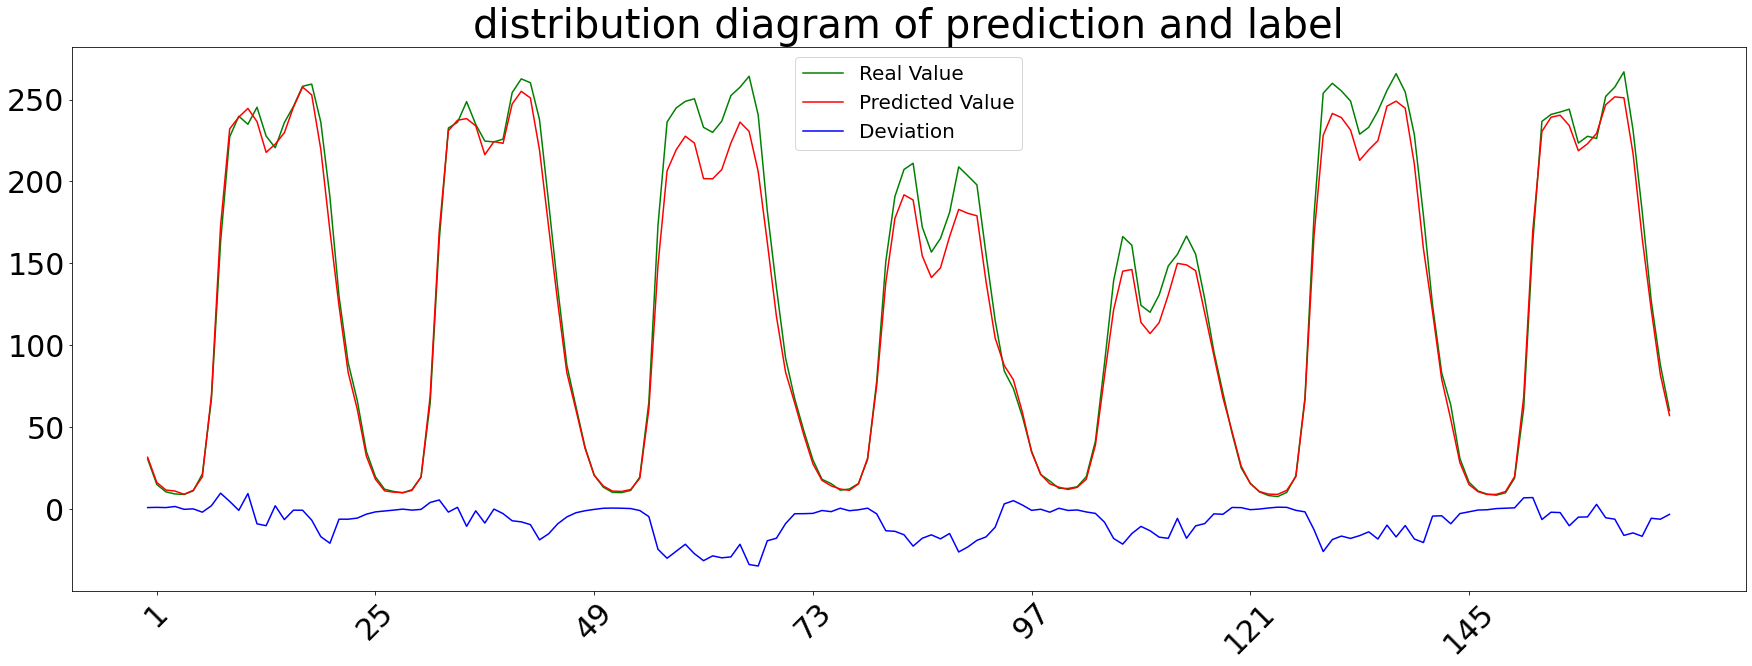

In [17]:
from matplotlib.font_manager import _rebuild
_rebuild()

# 可视化结果
Visualization.show_line_chart(poly_pd,poly_lb)
# 中文字体的问题，不影响后面的运行    

### 2.0.4 模型性能评价
- 为了对模型性能进行评价，我们计算衡量回归模型的常用指标，平均绝对误差（MAE），均方根误差（RMSE）和R方分数

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
print(mean_squared_error(poly_pd,poly_lb))
print(np.sqrt(mean_squared_error(poly_pd,poly_lb)))
print(r2_score(poly_pd,poly_lb))

145.36009440582058
12.056537413611778
0.9816604866964238


### 2.0.5 预测数据的类型、实例和格式

![datatype](./picture/datatypes.png)

![datatype](./picture/dataformats.png)

- Choice A ： 数据类型为 空间栅格，数据实例和格式矩阵（matrix2D）表示的数据预测

- Choice B ：数据类型为 时空栅格，数据实例和格式矩阵（matrix3D）表示的数据预测

- Choice C ：数据类型为 空间栅格，数据实例和格式图（graph+时序）表示的数据预测



### 2.0.6 作业 数据侧写/白描（profiling）

- 时间维度
- 空间维度
- 时空维度

这部分对原始时空数据的时间、空间、时空相关性进行数据白描，并加入可视化。

In [13]:
total_data.shape # 待分析的时空数据

(60, 400, 24)

使用 Pearson 系数对时间序列的全局相关性进行衡量。如果两条时间序列相似的话，那么它们之间的 Pearson 系数接近于 1 ；如果是负相关的，那么接近于 -1 ；如果没有相关性，Pearson 系数接近于 0 。


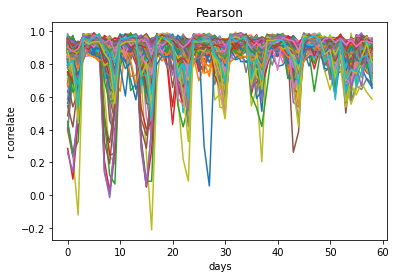

In [14]:
import scipy.stats as stats

# 首先对同一地点，每一天的时间序列和前一天时间序列的相关性计算
rlist = []
for i in range(400):
    rl = []
    for j in range(1, 60):
        r, h = stats.pearsonr(total_data[j - 1, i], total_data[j, i]) 
        rl.append(r)
    rlist.append(rl)
    
fig, ax = plt.subplots()
for i in range(400):
    ax.plot(rlist[i])
ax.set_xlabel('days')
ax.set_ylabel('r correlate')
ax.set_title('Pearson')

plt.show()

可以看到，不同采样地点的相关性稍有差别，但又都具有时间周期性，且大多数峰值为1，在7～8日左右会出现数据浮动和变化，造成相关性降低。

当天对应的四天前的相关性也可以衡量，即拉长采样区间，观察长时相关性。同样可以观测到类似结果。

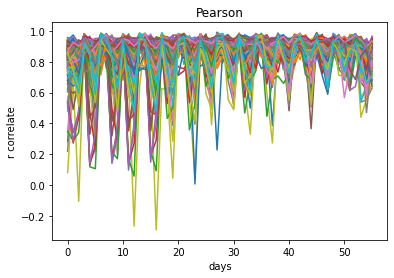

In [15]:
rlist = []
for i in range(400):
    rl = []
    for j in range(4, 60):
        r, h = stats.pearsonr(total_data[j - 4, i], total_data[j, i]) 
        rl.append(r)
    rlist.append(rl)
    
fig, ax = plt.subplots()  
for i in range(400):
    ax.plot(rlist[i])
ax.set_xlabel('days')
ax.set_ylabel('r correlate')
ax.set_title('Pearson')
plt.show()

这里先可视化不同空间点的时间数据。

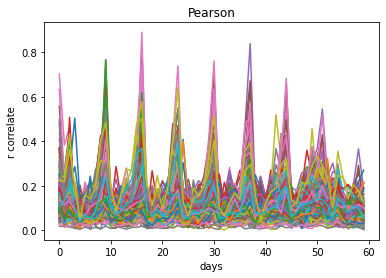

In [16]:
fig, ax = plt.subplots()  
for i in range(400):
    ax.plot(total_data.T[0][i])
ax.set_xlabel('days')
ax.set_ylabel('r correlate')
ax.set_title('Pearson')
plt.show()

之后，选择使用分层聚类的方法（hierarchal clustering）进行聚类预测，对不同空间维度的相似性进行衡量。

In [17]:
total_data_swap = total_data.swapaxes(0, 1) # 取400个栅格对应的时间切片
print(total_data_swap[0].shape)

total_space_data = []
for i in range(400):
    t = total_data_swap[i].ravel() # 拉直时间数据为一维
    total_space_data.append(t)

(60, 24)


分层聚类方法，这里采用自顶向上方法，算法采用ward方式，聚类数量取为4即可。

In [18]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

clustering = AgglomerativeClustering(linkage='ward', n_clusters=4)
clustering.fit(total_space_data)
print(clustering.labels_) # 对应的400个地点的聚类结果

[0 0 0 2 2 2 2 2 2 2 3 3 3 3 1 1 1 1 2 2 0 0 1 1 3 3 3 2 2 3 2 1 3 1 1 1 1
 1 2 2 0 0 1 1 3 3 3 3 3 2 2 3 1 1 1 1 1 1 2 2 1 1 1 1 3 3 3 2 1 1 1 1 1 1
 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 3 3 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 0 2 2 2 2 2 2 1
 1 1 1 2 1 1 1 1 1 3 3 3 0 2 2 2 2 2 2 1 1 1 2 2 1 1 1 1 1 3 3 3 2 2 2 2 2
 2 2 3 1 1 2 2 2 2 3 3 1 3 3 3 2 2 2 2 2 1 1 1 1 2 2 2 2 2 3 3 3 3 1 1 2 2
 2 1 1 1 1 1 1 1 1 2 2 2 2 3 3 3 3 1 0 2 2 1 1 1 1 1 1 3 2 2 2 2 2 2 3 3 3
 3 0 0 2 1 1 1 1 1 1 3 2 2 2 2 3 3 3 3 3 3 2 2 1 1 2 1 1 1 1 1 3 3 3 3 3 3
 2 2 3 3 2 2 1 1 2 1 2 2 3 2 2 3 3 3 0 3 2 2 3 3 2 2 1 1 2 2 2 3 3 2 2 2 0
 0 0 0 2 2 2 3 2 2 1 2 2 2 3 3 3 2 2 2 1 1 1 1 1 2 2 3 2 2 2 2 2 2 0 0 3 3
 3 3 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 2 2 2 3 3 1 1 1 1 1 1 1 3]


对应的分层聚类可视化结果如下。

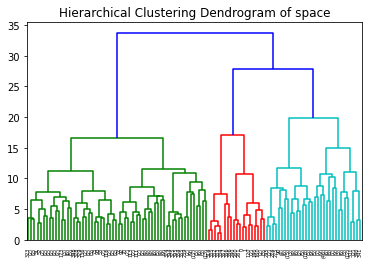

In [19]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(total_space_data)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram of space")
plot_dendrogram(model, truncate_mode="level", p=6)

可以得到不同空间点的相似程度和相关性。

同样可以对时间维度进行聚类预测，并得到结果如下。不同天的相关性也可以由此得到。

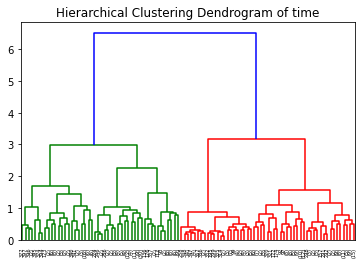

In [20]:
total_time_data = total_data[0]

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(total_time_data)

plt.title("Hierarchical Clustering Dendrogram of time")
plot_dendrogram(model, truncate_mode="level", p=6)

## 2.1 DeepST 模型的剪裁设计（空间CNN自动特征工程与时序人工特征工程的方法）
<a id='deepstpaper'></a>
我们课程的起点参考论文[DNN-Based Prediction Model for Spatio-Temporal Data](https://jtedu.cmri.cn/ingress/f9d35842-0e32-4d6f-99af-032316cb74c6-dl-0844147206-pod/files/paper/DNNBasedPredictionModelforSpatioTemporalData.pdf?_xsrf=2%7C1192ff5e%7C832de2267b9426c84c693f3ab8ea3723%7C1639798096)。
文中，作者提出了DeepST的框架，其整体架构如下图

- 模型的整体结构：

![model structure](./picture/model.png)

首先涉及到深度学习的超参数配置


In [9]:
# 超参数 
OPTIMIZER = keras.optimizers.SGD(lr=0.01)
LOSS = 'mean_squared_error'
BATCH_SIZE = 64
EPOCHS = 20

其次输入的数据格式需要进行设计

In [20]:
# 设置输入数据的格式，closeness、period、trend分别对应人工特征工程下时间维度的特征抽取后，准备放入模型的数据格式
closeness = layers.Input(shape=(20, 20, 3), name='closeness')
period = layers.Input(shape=(20, 20, 3), name='period')
trend = layers.Input(shape=(20, 20, 1), name='trend')
convlstmall = layers.Input(shape=(20,20, ),name='convlstmall')  #convLSTM的完整输入数据的格式
#数据类型是空间栅格，实例和格式都是以Matrics存储栅格数据 -choice A

## 2.1.1 `MiniDeepST`
在本案例中，由于缺少全局数据，故我们只考虑[DNN-Based Prediction Model for Spatio-Temporal Data](https://jtedu.cmri.cn/ingress/f9d35842-0e32-4d6f-99af-032316cb74c6-dl-0844147206-pod/files/paper/DNNBasedPredictionModelforSpatioTemporalData.pdf?_xsrf=2%7C1192ff5e%7C832de2267b9426c84c693f3ab8ea3723%7C1639798096)论文的左半部分，即时空数据部分。

模型结构非常简单，所包含的组件只有基本的卷积神经网络，我们将简化后的模型称为miniDeepST。

![mini-DeepST](./picture/mini-DeepST.png)

假设我们要预测t时刻的城市流量分布，首先把城市分割成`m*n`的网格，每个时刻城市的流量分布状况可以用一个`m*n`的矩阵表示，把这个矩阵看成像素矩阵，那么我们就可以卷积神经网络来分析提取城市流量分布的特征。虽然卷积神经网络能很好地提取流量值在空间分布上的特征，但是无法分析城市流量在时间顺序上的特点，解决这个问题有很多方法，这里我们用多个并行的卷积层来简单地拟合数据在时间上的分布。

由上图可以看出，有3个并行卷积层t、p、s。其中卷积层t的输入数据是时刻t前3个连续时刻的城市流量数据组成的3通道像素矩阵，代表着邻近时间数据的相似性；卷积层p的输入数据是距时刻t所在天数前三天中相同时刻的城市流量数据组成的3通道像素矩阵，代表数据在时间上的周期性；卷积层s的输入数据是时刻t所在周前一周同一时刻的城市流量数据组成的单通道像素矩阵，代表数据在时间上的趋势。

所谓聚合，简单来说就是把卷积层t、p、s的计算结果加权相加然后再通过一个卷积层。聚合层的输出再经过两个卷积层的计算后，把最终计算结果拉平成长度为m*n的向量，结果保存成向量的格式是因为在程序实现的过程中，我们通常要一次对一组结果（结果的个数为batch_size）计算损失函数的值，结果保存成一维向量有利于程序代码的编写。为了加快梯度下降最优质的求解速度以及提高模型准确度，所有的输入数据都做了归一化处理（这里采用了简单的[Max-Min归一化）](#maxminsection)，所以输出也必须保证在[0,1]之间，所以最后的卷积层2采用的激活函数为sigmoid函数，其余卷积层的激活函数为Relu函数（采用Relu作为卷积层的激活函数的原因可以参考论文[Image Net Classiﬁcation with Deep Convolutional Neural Networks](https://dl.acm.org/doi/abs/10.1145/3065386)。模型的更多细节请参考[原论文](#deepstpaper)。

In [21]:
# mini-DeepST模型构建
MiniDeepST_output = BuildModel.MiniDeepST(closeness, period, trend, filters=64, kernel_size=(3,3), activation='relu', use_bias=True)
MiniDeepST = Model(inputs=[closeness, period, trend], outputs=MiniDeepST_output)
MiniDeepST.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉下面一句statement的注释可以显示整个模型结构
MiniDeepST.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
period (InputLayer)             (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
trend (InputLayer)              (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 20, 20, 64)   1792        closeness[0][0]                  
____________________________________________________________________________________________

## 2.1.2 `MiniSTResNet`: MiniDeepST + ResNet
残差网络（[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)）在图像领域已然成为了一种主流模型。残差网络是为了解决深度神经网络（DNN）隐藏层过多时的网络退化问题而提出。这里的退化问题是指：当网络隐藏层变多时，网络的准确度达到饱和然后急剧退化，而且这个退化不是由于过拟合引起的。

如果在流量预测任务中，仅使用miniDeepST性能还不足以另我们满意，可以考虑在miniDeepST的基础上加上[残差块](#resunit)，因为其对网络退化问题的解决，可能对最后性能产生改进影响。残差单元可以以跳层连接的形式实现，即将单元的输入直接与单元输出加在一起，然后再激活。因此残差网络可以轻松地用主流的自动微分深度学习框架实现，直接使用BP算法更新参数。在前向传播时，输入信号可以从任意低层直接传播到高层。由于包含了一个天然的恒等映射，一定程度上可以解决网络退化问题。

网络退化现象：加了多层网络后，比少层数的网络相比，训练时loss不降，测试时性能也不好。

![mini-ST-ResNet](./picture/mini-ST-ResNet.png)


<a id='resunit'></a>
#### 残差块 ResUnit
![ResNet-Unit](./picture/resnet.png)

In [22]:
MiniSTResNet_output = BuildModel.MiniSTResNet(closeness, period, trend, filters=64, kernel_size=(3,3), activation='relu', use_bias=True)
MiniSTResNet = Model(inputs=[closeness, period, trend], outputs=MiniSTResNet_output)
MiniSTResNet.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉下面一句statement的注释可以显示整个模型结构
MiniSTResNet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
period (InputLayer)             (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
trend (InputLayer)              (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 20, 20, 64)   1792        closeness[0][0]                  
____________________________________________________________________________________________

## 2.1.3  非妥当地增加`ConvLSTM`（空域CNN和时域RNN联合自动特征工程的方法）
其实时序方面的也有与空间联合开展的机器自动特征工程。可参考论文[Long-Term Mobile Traffic Forecasting Using Deep Spatio-Temporal Neural Networks](https://dl.acm.org/doi/abs/10.1145/3209582.3209606)中使用卷积LSTM（convLSTM）和3D卷积（Conv3D）联合实现长期流量的预测中的两种模型。

- ConvLSTM，由施行健提出并首度发表于[NIPS 2015](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)。其核心本质还是和LSTM一样，将上一层的输出作为下一层的输入。不同的地方在于ConvLSTM加入了卷积操作之后，不仅能够得到时序关系，还能够像卷积层一样提取空间特征，这样ConvLSTM就可以同时提取时间特征和空间特征（时空特征），并且状态与状态之间的切换也换成了卷积运算。
![convLSTM](./picture/ConvLSTMforprecipitation.png)

- 3D卷积，顾名思义，卷积核核在3个维度上滑动，从使用其核从3D数据中提取3D的空间特征。--其中一维可看成时间维。[Conv3D论文](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)
![Conv3D](./picture/conv3D.jpg)


可以尝试在miniSTResNet模型上，尝试强制增加convLSTM（不鼓励这种做法，bad example）![目前工具箱上接上convLSTM的尝试](./picture/STConvLSTM.png)


In [23]:
ConvLSTM_output = BuildModel.ConvLSTM(closeness, period, trend)
ConvLSTM = Model(inputs=[closeness, period, trend], outputs=ConvLSTM_output)
ConvLSTM.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉注释可以显示整个模型结构
ConvLSTM.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
period (InputLayer)             (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
trend (InputLayer)              (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 20, 20, 64)   1792        closeness[0][0]                  
____________________________________________________________________________________________

In [ ]:
# %load BuildModel.py

## 2.2  `DeepST`修剪模型的训练和预测

## 数据集处理

In [11]:
# 获取预处理后的数据
#total_data_path = './data/total.vocab’去掉？？？
train_data, test_data = TrainModel.MakeDataset(total_data_path)

# 获取训练数据
c_train = train_data[:, :, :, 0:3]
p_train = train_data[:, :, :, 3:6]
t_train = train_data[:, :, :, 6:7]
train_label = train_data[:, :, :, -1]
train_label = np.reshape(train_label, [train_data.shape[0], 400])

# 获取测试的数据
c_test = test_data[:, :, :, 0:3]
p_test = test_data[:, :, :, 3:6]
t_test = test_data[:, :, :, 6:7]
test_label = test_data[:, :, :, -1]
test_label = np.reshape(test_label, [test_data.shape[0], 400])
STEPS_PER_EPOCH = int(train_data.shape[0] // BATCH_SIZE)

(60, 400, 24)


## 2.2.1 MiniDeepST模型的训练和预测

In [25]:
# 训练和保存模型
print('-> Start to train MiniDeepST model!')
MiniDeepST_history = MiniDeepST.fit_generator(generator=TrainModel.Generator([c_train, p_train, t_train], train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
MiniDeepST_path = './model/MiniDeepST.h5'
MiniDeepST.save_weights(MiniDeepST_path)
print('-> Finish to save trained MiniDeepST model')

# 保存预测数据
MiniDeepST_result_path = './data/MiniDeepST_result.vocab'
MiniDeepST_predict = MiniDeepST.predict([c_test, p_test, t_test], batch_size=BATCH_SIZE ,verbose=1)
print(MiniDeepST_predict.shape)
TrainModel.WriteData(MiniDeepST_result_path, MiniDeepST_predict)

-> Start to train MiniDeepST model!
Epoch 1/20
15/15 [==============================] - 4s 270ms/step - loss: 0.0653
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0268
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0222
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0208
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0198
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0189
Epoch 8/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0182
Epoch 9/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0176
Epoch 10/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0170
Epoch 11/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0165
Epoch 12/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0160


## 2.2.2  MiniSTResNet模型的训练和预测

In [26]:
# 训练和保存模型
print('-> Start to train MiniSTResNet model!')
MiniSTResNet_history = MiniSTResNet.fit_generator(generator=TrainModel.Generator([c_train, p_train, t_train], train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
MiniSTResNet_path = './model/MiniSTResNet.h5'
MiniSTResNet.save_weights(MiniSTResNet_path)
print('-> Finish to save MiniSTResNet model')

# 保存预测数据
MiniSTResNet_result_path = './data/MiniSTResNet_result.vocab'
MiniSTResNet_predict = MiniSTResNet.predict([c_test, p_test, t_test], batch_size=BATCH_SIZE ,verbose=1)
TrainModel.WriteData(MiniSTResNet_result_path, MiniSTResNet_predict)

-> Start to train MiniSTResNet model!
Epoch 1/20
15/15 [==============================] - 1s 39ms/step - loss: 0.0339
Epoch 2/20
15/15 [==============================] - 0s 16ms/step - loss: 0.0208
Epoch 3/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0173
Epoch 4/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0149
Epoch 5/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0132
Epoch 6/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0120
Epoch 7/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0112
Epoch 8/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0105
Epoch 9/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0100
Epoch 10/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0097
Epoch 11/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0094
Epoch 12/20
15/15 [==============================] - 0s 15ms/step - loss: 0.0091

## 2.2.3 错误的ConvLSTM模型的训练与预测

In [27]:
# # 训练和保存模型
print('-> Start to train ConvLSTM model!')
ConvLSTM_history = ConvLSTM.fit_generator(generator=TrainModel.Generator([c_train, p_train, t_train], train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
ConvLSTM_path = './model/ConvLSTM.h5'
ConvLSTM.save_weights(ConvLSTM_path)
print('-> Finish to save trained ConvLSTM model')

# # 保存预测数据
ConvLSTM_result_path = './data/ConvLSTM_result.vocab'
ConvLSTM_predict = ConvLSTM.predict([c_test, p_test, t_test], batch_size=BATCH_SIZE ,verbose=1)
TrainModel.WriteData(ConvLSTM_result_path, ConvLSTM_predict)

-> Start to train ConvLSTM model!
Epoch 1/20
15/15 [==============================] - 3s 229ms/step - loss: 0.0452
Epoch 2/20
15/15 [==============================] - 1s 53ms/step - loss: 0.0205
Epoch 3/20
15/15 [==============================] - 1s 51ms/step - loss: 0.0183
Epoch 4/20
15/15 [==============================] - 1s 50ms/step - loss: 0.0167
Epoch 5/20
15/15 [==============================] - 1s 50ms/step - loss: 0.0155
Epoch 6/20
15/15 [==============================] - 1s 51ms/step - loss: 0.0145
Epoch 7/20
15/15 [==============================] - 1s 50ms/step - loss: 0.0137
Epoch 8/20
15/15 [==============================] - 1s 50ms/step - loss: 0.0130
Epoch 9/20
15/15 [==============================] - 1s 49ms/step - loss: 0.0125
Epoch 10/20
15/15 [==============================] - 1s 51ms/step - loss: 0.0120
Epoch 11/20
15/15 [==============================] - 1s 52ms/step - loss: 0.0116
Epoch 12/20
15/15 [==============================] - 1s 49ms/step - loss: 0.0112
Ep

In [28]:
# 保存预测的真实值
labels = test_label
labels_savepath = './data/labels.vocab'
TrainModel.WriteData(labels_savepath, labels)

update:  ./data/labels.vocab
Finish to save data!


In [ ]:
# %load TrainModel.py

## 2.3 `ConvLSTM`模型设计（空间CNN自动特征工程与时序LSTM自动特征工程的联合方法）

In [13]:
# 超参数
OPTIMIZER = keras.optimizers.SGD(lr=0.01)
LOSS = 'mean_squared_error'
BATCH_SIZE = 16
EPOCHS = 10

# 设置输入数据的形式
data = layers.Input(shape=(20, 20, 168), name='data')

### 数据集制作

In [14]:
# 获取预处理后的数据
# total_data_path = './data/total.vocab'
train_data, test_data = TrainModel.MakeConvLSTMDataset(total_data_path)

# 获取训练数据
input_train = train_data[:, :, :, :-1]
train_label = train_data[:, :, :, -1]
train_label = np.reshape(train_label, [train_data.shape[0], 400])

# 获取测试的数据
input_test = test_data[:, :, :, :-1]
test_label = test_data[:, :, :, -1]
test_label = np.reshape(test_label, [test_data.shape[0], 400])
STEPS_PER_EPOCH = int(train_data.shape[0] // BATCH_SIZE)

(60, 400, 24)


### 2.3.1 `ConvLSTM`

由施行健提出并首度发表于[NIPS 2015](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)。其核心本质还是和LSTM一样，将上一层的输出作为下一层的输入。不同的地方在于ConvLSTM加入了卷积操作之后，不仅能够得到时序关系，还能够像卷积层一样提取空间特征，这样ConvLSTM就可以同时提取时间特征和空间特征（时空特征），并且状态与状态之间的切换也换成了卷积运算。

![convLSTM](./picture/ConvLSTMforprecipitation.png)

In [14]:
ConvLSTMModel_output = BuildModel.ConvLSTM2(data)
ConvLSTMModel = Model(inputs=[data], outputs=ConvLSTMModel_output)
ConvLSTMModel.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉注释可以显示整个模型结构
ConvLSTMModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 20, 20, 168)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 64)   96832       data[0][0]                       
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 20, 20, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 20, 20, 64)   36928       re_lu_1[0][0]                    
____________________________________________________________________________________________

### 2.3.2 作业 `ConvLSTM`+Dropout
在机器学习的模型中，如果模型复杂度太高，而训练数据又不充分的情况下，训练出来的模型很容易产生过拟合的现象。在训练神经网络的时候经常会遇到过拟合的问题，过拟合具体表现在：模型在训练数据上损失函数较小，预测准确率较高；但是在测试数据上损失函数比较大，预测准确率较低。过拟合是很多机器学习的通病。如果模型过拟合，那么得到的模型几乎不能用。
   训练深度神经网络的时候，总是会遇到两大缺点：容易过拟合、费时。Dropout可以比较有效的缓解过拟合的发生，在一定程度上达到正则化的效果。
   Dropout可以作为训练深度神经网络的一种trick供选择。在每个训练批次中，通过忽略一定比例的神经元，可以明显地减少过拟合现象。这种方式可以减少神经元间的相互作用，神经元相互作用是指某些神经元依赖其他神经元才能发挥作用。说简单一点就是：在前向传播的时候，让某个神经元的激活值以一定的概率p停止工作，这样可以使模型泛化性更强，因为它不会太依赖某些局部的特征。
   

 构造过拟合场景（训练时loss下降，但测试时表现不好），自己摸索如何加入dropout防止过拟合，并评估效果。
 
 如下的新模型的实例是加入了Dropout层的，其模型已经定义在`TrainModel`中，同样地，进行实例化和模型编译，如下。有关过拟合和其解决的内容见后。

In [15]:
ConvLSTMModel_output = BuildModel.ConvLSTM2_Dropout(data)
ConvLSTMModel = Model(inputs=[data], outputs=ConvLSTMModel_output)
ConvLSTMModel.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉注释可以显示整个模型结构
ConvLSTMModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 20, 20, 168)  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 20, 20, 64)   96832       data[0][0]                       
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 20, 20, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 20, 20, 64)   36928       re_lu_3[0][0]                    
____________________________________________________________________________________________

## 2.4 `ConvLSTM`模型的训练和预测

### 2.4.1 `ConvLSTM`模型的训练和预测

In [30]:
# 训练和保存模型
print('-> Start to train ConvLSTM model!')
ConvLSTMModel_history = ConvLSTMModel.fit_generator(generator= TrainModel.GeneratorConvLSTM(input_train, train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
ConvLSTMModel_path = './model/ConvLSTMModel.h5'
ConvLSTMModel.save_weights(ConvLSTMModel_path)
print('-> Finish to save ConvLSTM model')

# 保存预测数据
ConvLSTMModel_result_path = './data/ConvLSTMModel_result.vocab'
ConvLSTMModel_predict = ConvLSTMModel.predict(input_test, batch_size=BATCH_SIZE ,verbose=1)
print(ConvLSTMModel_predict.shape)
TrainModel.WriteData(ConvLSTMModel_result_path, ConvLSTMModel_predict)

-> Start to train ConvLSTM model!
Epoch 1/10
60/60 [==============================] - 23s 385ms/step - loss: 0.0504
Epoch 2/10
60/60 [==============================] - 22s 373ms/step - loss: 0.0154
Epoch 3/10
60/60 [==============================] - 22s 371ms/step - loss: 0.0132
Epoch 4/10
60/60 [==============================] - 22s 371ms/step - loss: 0.0122
Epoch 5/10
60/60 [==============================] - 22s 375ms/step - loss: 0.0115
Epoch 6/10
60/60 [==============================] - 23s 376ms/step - loss: 0.0109
Epoch 7/10
60/60 [==============================] - 22s 369ms/step - loss: 0.0105
Epoch 8/10
60/60 [==============================] - 22s 366ms/step - loss: 0.0101
Epoch 9/10
60/60 [==============================] - 22s 364ms/step - loss: 0.0097
Epoch 10/10
60/60 [==============================] - 22s 374ms/step - loss: 0.0095
-> Finish to save ConvLSTM model
312/312 [==============================] - 2s 7ms/step
(312, 400)
Finish to save data!


### 2.4.2 作业 `ConvLSTM`+`Dropout`模型的训练和预测

这一部分的主要任务有两个：
1. 面向`ConvLSTM`模型，通过改变迭代轮数epochs和模型的参数量、层数使得模型对数据过拟合
2. 同样的参数设定和数据，使用`ConvLSTM`+`Dropout`模型进行训练和评估，对比二者的结果和评分，证实dropout对于过拟合的抑制效果

这里选择改变学习率和模型参数量使得模型对数据过拟合。

In [15]:
# 超参数重新设定，学习率降低
OPTIMIZER = keras.optimizers.SGD(lr=0.01)
LOSS = 'mean_squared_error'
EPOCHS = 60 # epochs改变

# 模型改变，增加了层数和参数量，具体见BuildModel
ConvLSTMModel_output = BuildModel.ConvLSTM2_Dropout_overfit(data)
ConvLSTMModel = Model(inputs=[data], outputs=ConvLSTMModel_output)
ConvLSTMModel.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)

将此次的训练模型单独保存。

In [16]:
# 训练和保存模型
# 加入了验证集，方便验证是否过拟合
print('-> Start to train ConvLSTM model with over fitting!')
ConvLSTMModel_history = ConvLSTMModel.fit_generator(generator=TrainModel.GeneratorConvLSTM(input_train, train_label, STEPS_PER_EPOCH, BATCH_SIZE),
                                                    steps_per_epoch=STEPS_PER_EPOCH, 
                                                    epochs=EPOCHS, 
                                                    validation_data=(input_test, test_label), 
                                                    validation_steps=6,
                                                    verbose=1, 
                                                    shuffle=True)

ConvLSTMModel_path = './model/ConvLSTMModel_over_fitting.h5'
ConvLSTMModel.save_weights(ConvLSTMModel_path)
print('-> Finish to save ConvLSTM model over fitting')

# 保存预测数据
ConvLSTMModel_result_path = './data/ConvLSTMModel_over_fitting_result.vocab'
ConvLSTMModel_predict = ConvLSTMModel.predict(input_test, batch_size=BATCH_SIZE ,verbose=1)
print(ConvLSTMModel_predict.shape)
TrainModel.WriteData(ConvLSTMModel_result_path, ConvLSTMModel_predict)

-> Start to train ConvLSTM model with over fitting!
Epoch 1/60
60/60 [==============================] - 28s 465ms/step - loss: 0.0566 - val_loss: 0.0263
Epoch 2/60
60/60 [==============================] - 22s 375ms/step - loss: 0.0298 - val_loss: 0.0216
Epoch 3/60
60/60 [==============================] - 23s 381ms/step - loss: 0.0243 - val_loss: 0.0198
Epoch 4/60
60/60 [==============================] - 23s 386ms/step - loss: 0.0216 - val_loss: 0.0189
Epoch 5/60
60/60 [==============================] - 22s 366ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 6/60
60/60 [==============================] - 22s 370ms/step - loss: 0.0189 - val_loss: 0.0180
Epoch 7/60
60/60 [==============================] - 22s 364ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 8/60
60/60 [==============================] - 21s 358ms/step - loss: 0.0173 - val_loss: 0.0175
Epoch 9/60
60/60 [==============================] - 21s 354ms/step - loss: 0.0166 - val_loss: 0.0173
Epoch 10/60
60/60 [====================

将训练结果和测试结果Loss可视化，观察是否出现过拟合现象。

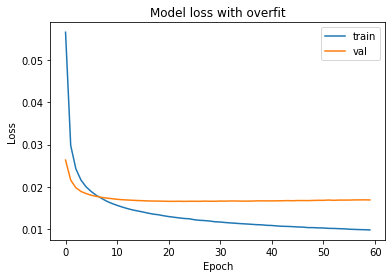

In [17]:
plt.plot(ConvLSTMModel_history.history['loss'], label='train')
plt.plot(ConvLSTMModel_history.history['val_loss'], label='val')
#plt.plot(ConvLSTMModel_val_history.history['loss'], label='test/val')
plt.title('Model loss with overfit')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

由上图可以看到，训练曲线仍旧平稳，但验证集曲线已经出现了上翘，不再收敛。此时没有early-stopping，且参数过拟合了。

这时，再使用相同的迭代轮数对加入Dropout层的新模型进行训练和验证，对比观察结果。

In [18]:
ConvLSTMModel_output = BuildModel.ConvLSTM2_Dropout(data) # 使用带有dp=0.5的新模型
ConvLSTMModel = Model(inputs=[data], outputs=ConvLSTMModel_output)
ConvLSTMModel.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)

print('-> Start to train ConvLSTM_Dropout model!')
ConvLSTMModel_history = ConvLSTMModel.fit_generator(generator=TrainModel.GeneratorConvLSTM(input_train, train_label, STEPS_PER_EPOCH, BATCH_SIZE),
                                                    steps_per_epoch=STEPS_PER_EPOCH, 
                                                    epochs=EPOCHS, 
                                                    validation_data=(input_test, test_label), 
                                                    validation_steps=6,
                                                    verbose=1, 
                                                    shuffle=True)

ConvLSTMModel_path = './model/ConvLSTMModel_dp.h5'
ConvLSTMModel.save_weights(ConvLSTMModel_path)
print('-> Finish to save ConvLSTM_Dropout model')

# 保存预测数据
ConvLSTMModel_result_path = './data/ConvLSTMModel_dp_result.vocab'
ConvLSTMModel_predict = ConvLSTMModel.predict(input_test, batch_size=BATCH_SIZE ,verbose=1)
print(ConvLSTMModel_predict.shape)
TrainModel.WriteData(ConvLSTMModel_result_path, ConvLSTMModel_predict)


-> Start to train ConvLSTM_Dropout model!
Epoch 1/60
60/60 [==============================] - 22s 373ms/step - loss: 0.0659 - val_loss: 0.0187
Epoch 2/60
60/60 [==============================] - 21s 353ms/step - loss: 0.0346 - val_loss: 0.0171
Epoch 3/60
60/60 [==============================] - 21s 351ms/step - loss: 0.0270 - val_loss: 0.0164
Epoch 4/60
60/60 [==============================] - 21s 352ms/step - loss: 0.0231 - val_loss: 0.0159
Epoch 5/60
60/60 [==============================] - 21s 351ms/step - loss: 0.0208 - val_loss: 0.0158
Epoch 6/60
60/60 [==============================] - 21s 353ms/step - loss: 0.0194 - val_loss: 0.0155
Epoch 7/60
60/60 [==============================] - 21s 351ms/step - loss: 0.0182 - val_loss: 0.0154
Epoch 8/60
60/60 [==============================] - 21s 352ms/step - loss: 0.0173 - val_loss: 0.0154
Epoch 9/60
60/60 [==============================] - 21s 354ms/step - loss: 0.0167 - val_loss: 0.0152
Epoch 10/60
60/60 [==============================

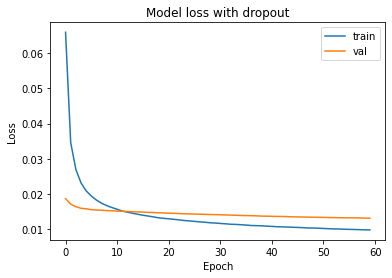

In [19]:
plt.plot(ConvLSTMModel_history.history['loss'], label='train')
plt.plot(ConvLSTMModel_history.history['val_loss'], label='val')
#plt.plot(ConvLSTMModel_val_history.history['loss'], label='test/val')
plt.title('Model loss with dropout')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

可以明显的看出，val曲线不再上翘，说明没有过拟合，说明加入dropout层可以有效避免过拟合现象。

如上为实验过程和结果。

# 三、可视化
![visulization](./picture/visualization.png)

## 3.1  Loss可视化

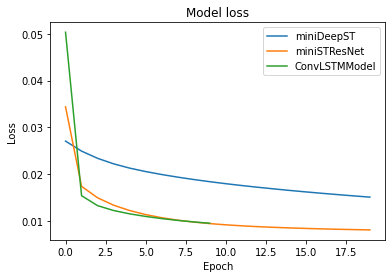

In [31]:
# 显示训练Loss
plt.plot(MiniDeepST_history.history['loss'], label='miniDeepST')
plt.plot(MiniSTResNet_history.history['loss'], label='miniSTResNet')
# plt.plot(ConvLSTM_history.history['loss'], label='ConvLSTM')
plt.plot(ConvLSTMModel_history.history['loss'], label='ConvLSTMModel')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 3.2  结果可视化

### 3.2.1  获取预测结果

In [32]:
# 获取预测数据并归一化
ConvLSTMModel_result_path = './data/ConvLSTMModel_result.vocab'
MiniDeepST_result_path = './data/MiniDeepST_result.vocab'
MiniSTResNet_result_path = './data/MiniSTResNet_result.vocab'
# ConvLSTM_result_path = './data/ConvLSTM_result.vocab'
max_min_path = './data/loc_max_mix.vocab'
label_path = './data/labels.vocab'

ConvLSTMModel_result = Visualization.DecodeData(ConvLSTMModel_result_path,max_min_path)
MiniDeepST_result = Visualization.DecodeData(MiniDeepST_result_path, max_min_path)
MiniSTResNet_result = Visualization.DecodeData(MiniSTResNet_result_path, max_min_path)
# ConvLSTM_result = Visualization.DecodeData(ConvLSTM_result_path, max_min_path)
label = Visualization.DecodeData(label_path, max_min_path) 

# 构建预测结果字典
# results_dict = {'MiniDeepST':MiniDeepST_result, 'MiniSTResNet': MiniSTResNet_result,'MiniSTRConvLSTM':ConvLSTM_result}
results_dict = {'ConvLSTMModel':ConvLSTMModel_result,'MiniDeepST':MiniDeepST_result, 'MiniSTResNet': MiniSTResNet_result}

In [33]:
# ConvLSTMModel性能评估
ConvLSTMModel_MAE = Visualization.CalculateMAE(ConvLSTMModel_result, label)
ConvLSTMModel_RMSE = Visualization.CalculateRMSE(ConvLSTMModel_result, label)
ConvLSTMModel_R2_score = Visualization.CalculateR2score(ConvLSTMModel_result, label)

# MiniDeepST 性能评估
MiniDeepST_MAE = Visualization.CalculateMAE(MiniDeepST_result, label)
MiniDeepST_RMSE = Visualization.CalculateRMSE(MiniDeepST_result, label)
MiniDeepST_R2_score = Visualization.CalculateR2score(MiniDeepST_result, label)

# MiniSTResNet 性能评估
MiniSTResNet_MAE = Visualization.CalculateMAE(MiniSTResNet_result, label)
MiniSTResNet_RMSE = Visualization.CalculateRMSE(MiniSTResNet_result, label)
MiniSTResNet_R2_score = Visualization.CalculateR2score(MiniSTResNet_result, label)


# # ConvLSTM 性能评估
# ConvLSTM_MAE = Visualization.CalculateMAE(ConvLSTM_result, label)
# ConvLSTM_RMSE = Visualization.CalculateRMSE(ConvLSTM_result, label)
# ConvLSTM_R2_score = Visualization.CalculateR2score(ConvLSTM_result, label)

print('ConvLSTMModel   -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (ConvLSTMModel_MAE, ConvLSTMModel_RMSE, ConvLSTMModel_R2_score))
print('MiniDeepST   -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (MiniDeepST_MAE, MiniDeepST_RMSE, MiniDeepST_R2_score))
print('MiniSTResNet -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (MiniSTResNet_MAE, MiniSTResNet_RMSE, MiniSTResNet_R2_score))
# print('ConvLSTM     -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (ConvLSTM_MAE, ConvLSTM_RMSE, ConvLSTM_R2_score))

ConvLSTMModel   -> MAE: 23.369988.  RMSE: 30.611021.  R2_score: -0.033177.
MiniDeepST   -> MAE: 21.856652.  RMSE: 28.833812.  R2_score: -0.116035.
MiniSTResNet -> MAE: 20.520550.  RMSE: 26.967118.  R2_score: 0.284836.


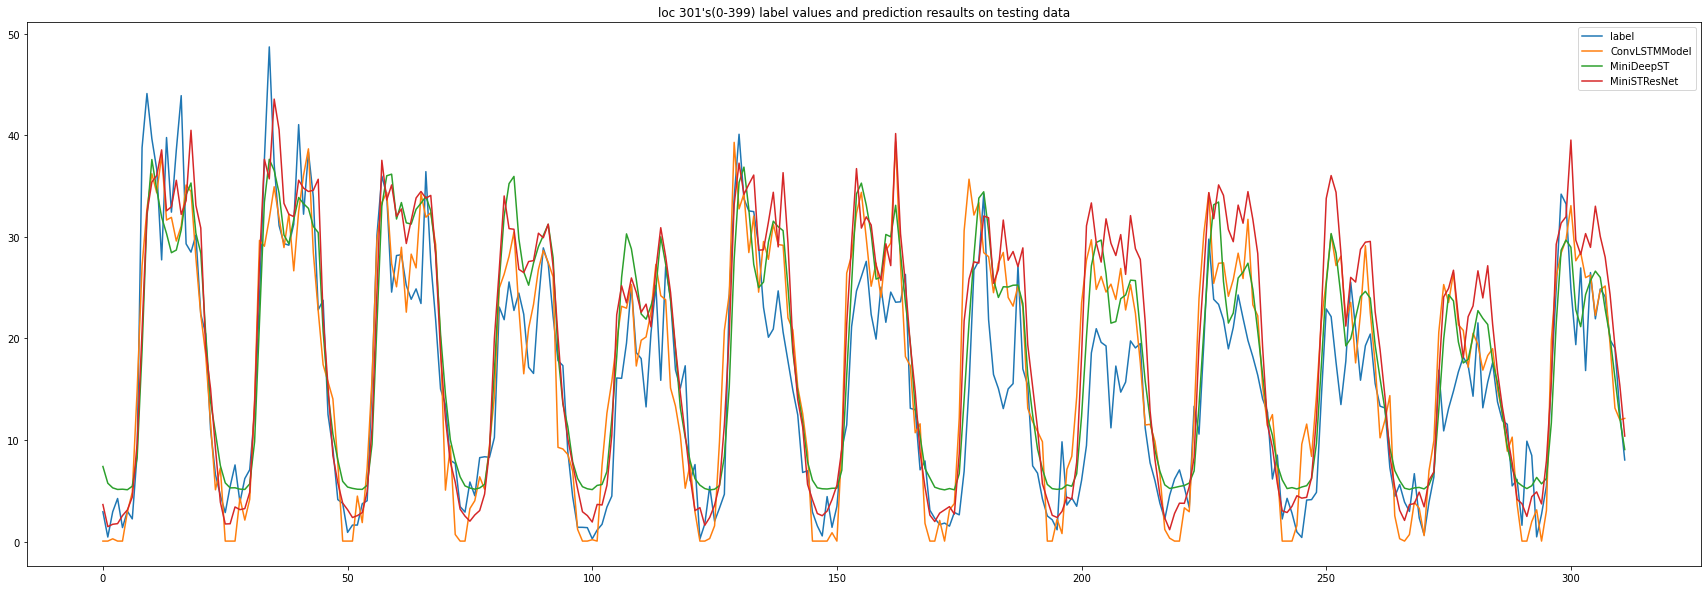

In [34]:
# 显示预测某区域的预测曲线和真实曲线
loc_id = 301
Visualization.ShowPrediction(loc_id, results_dict, label)

### 3.2.2 预测结果热力图

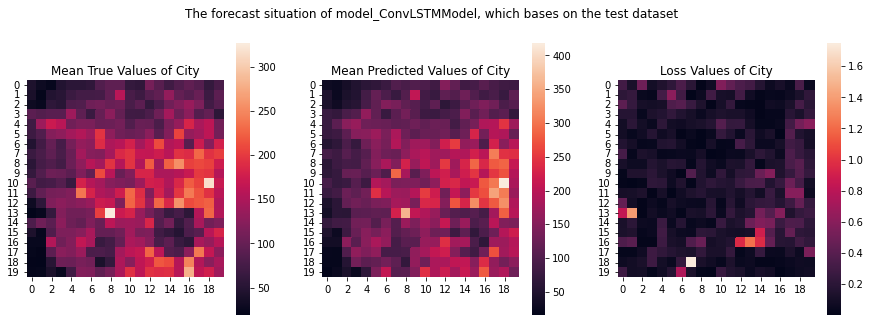

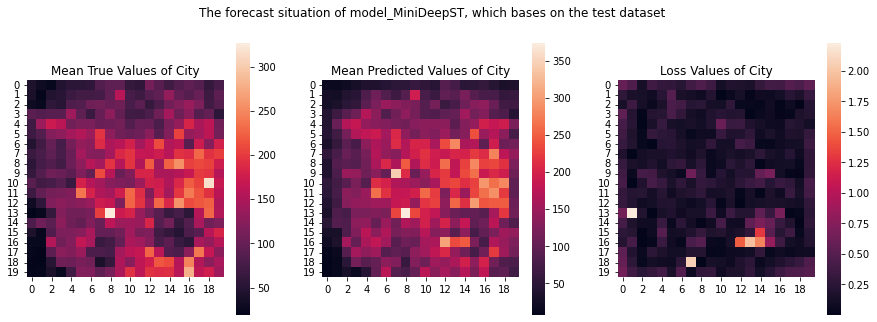

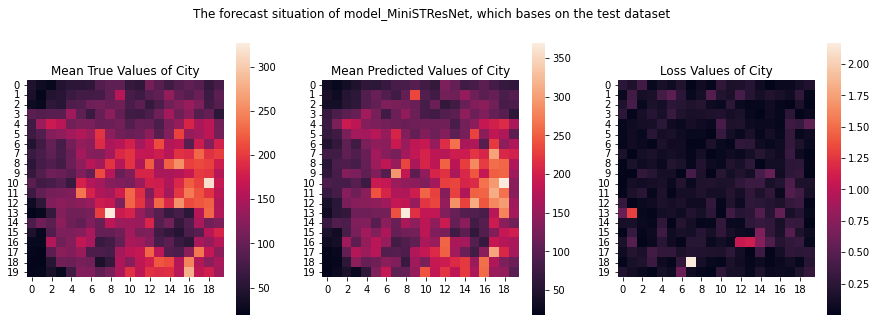

In [35]:
# 显示热力图
hour = 12
Visualization.HotMap(hour, results_dict, label)

In [ ]:
# %load Visualization.py